# Random Forest for coastal feature extraction.

The code and this notebook can be found on the github repo: https://github.com/Aryal007/ml_satellite_image_segmentation

In [1]:
from utils.data import Data
%matplotlib inline

* We encapsulate all our functions related to data processing in utils.data
* tiff_filename and shp_filename are two required parameters for Data class
* The other parameters include classes (Index for labels and its corresponding name), and default channel (for visualization in case of tiffs with multiple channels)
* We can use data.get_constants() to print all the parameters for data object

In [2]:
tiff_name = "./Data/Images/5_band3.tif"
shp_name = "./Data/Labels/5_band3.shp"
data = Data(tiff_name, shp_name, classes = ["water", "land"])
data.get_constants()

Tiff: ./Data/Images/5_band3.tif
Shp: ./Data/Labels/5_band3.shp
Classes: ['water', 'land']
Default channel: (1, 2, 3)
Savepath: ./outputs


Once we have the object created for Data class
* data.read_tiff() -> reads the tiff_filename and returns rasterio object
* data.read_shp() -> reads shp_filename and returns geopandas object
* data.check_crs() -> raises an error if the crs of two objects don't match, verbose prints the crs for each object
* data.get_tiff_details(tiff) -> reads the rasterio object and prints details of the tiff

In [3]:
tiff = data.read_tiff()
shp = data.read_shp()
data.check_crs(shp.crs, tiff.crs, verbose=True)

CRS 1: EPSG:3338, CRS 2: EPSG:3338


In [4]:
data.get_tiff_details(tiff)

Filename: ./Data/Images/5_band3.tif
Bands: 5
Width (pixels): 7968
Height (pixels): 7773
CRS: EPSG:3338
Bounds: BoundingBox(left=381506.24129992817, bottom=2259715.20420001, right=384295.0412999274, top=2262435.754200009)


We need to convert geopandas polygon information to masks that correspond with given tiff image. For this, we can use data.get_mask(). This function burns the polygon into tiff file to produce image mask of dimensions tiff_height * tiff_width * len(classes) where classes represent the index, name dictionary for output labels. (Since we have only two labels (land and water), mask will have 2 channels)

In [5]:
mask = data.get_mask()

/home/ecology/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


### Data Visualization
* data.view_tiff(tiff) -> reads rasterio object from read_tiff() and uses default channels to visualize as RGB
* you can also pass an integer as parameter channel to visualize that channel only
* data.view_mask(mask) -> reads the mask numpy array and visualizes it as labeled images

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


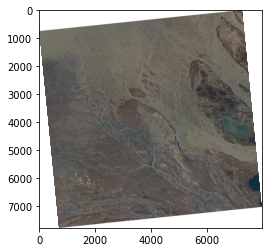

In [6]:
data.view_tiff(tiff)

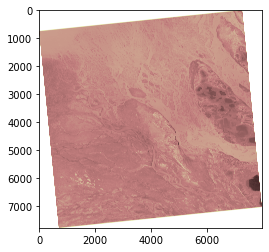

In [7]:
data.view_tiff(tiff, channel=1)

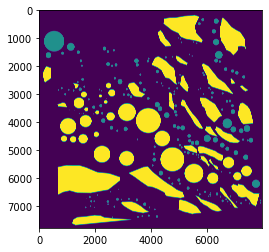

In [8]:
data.view_mask(mask)

In [9]:
X, y = data.get_Xy(tiff, mask, n_sample = 2000000)
X_train, X_test, y_train, y_test = data.train_test_split(X, y, save=False)

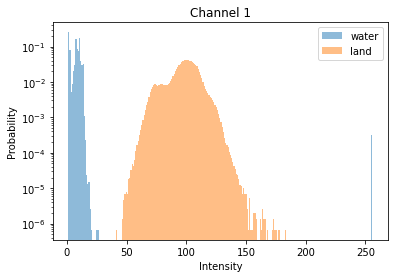

In [10]:
data.get_histogram(X_train, y_train, channel = 1)

In [11]:
from utils.estimators import Dataset, Classifier

In [12]:
dataset = Dataset(X_train, X_test, y_train, y_test)
dataset.info()

No. of classes: 2
Class labels: ['water', 'land']
Total data samples: 4000000
Train samples: 3000000
	 0:water = 1500361
	 1:land = 1499639
Test stats: 1000000
	 0:water = 499639
	 1:land = 500361


In [13]:
classifier = Classifier()

### Lets create a test set from another tiff to test across geographic generalization

/home/ecology/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


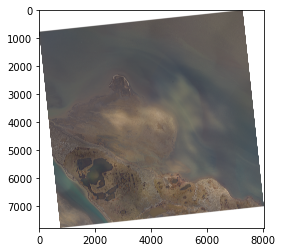

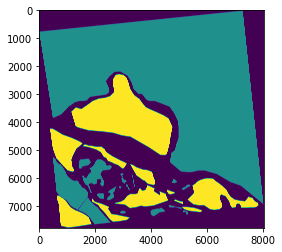

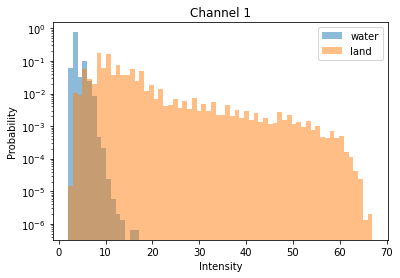

In [14]:
tiff_filename = "./Data/Images/5_band15.tif"
shp_filename = "./Data/Labels/5_band15.shp"
test_data = Data(tiff_filename, shp_filename, classes = ["water", "land"])
test_tiff = test_data.read_tiff() 
actual_mask = test_data.get_mask()
test_data.view_tiff(test_tiff)
test_data.view_mask(actual_mask)
_X, _y = data.get_Xy(test_tiff, actual_mask, n_sample = 2000000)
_X_train, _X_test, _y_train, _y_test = data.train_test_split(_X, _y, save=False)
test_dataset = Dataset(_X_train, _X_test, _y_train, _y_test)
test_data.get_histogram(_X_train, _y_train, channel = 1)

### Testing across samples from same tiff


Random Forest
Elapsed_time training  12.508084 
Accuracy on train Set: 
1.0
Accuracy on Test Set: 
1.0
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    499639
           1       1.00      1.00      1.00    500361

    accuracy                           1.00   1000000
   macro avg       1.00      1.00      1.00   1000000
weighted avg       1.00      1.00      1.00   1000000

Confusion Matrix: 
[[499639      0]
 [     0 500361]]


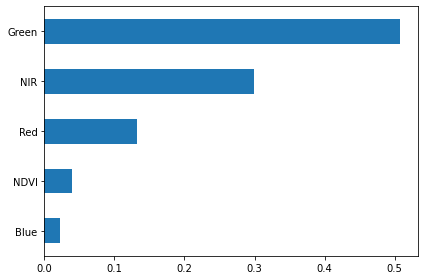

In [15]:
classifier.random_forest(trainX=dataset.trainX, trainY=dataset.trainY, testX=dataset.testX, testY=dataset.testY,
                  grid_search=False, train=True, n_estimators = 10, max_depth = 10, feature_importance=True)

### Testing on a different geographical region

In [16]:
classifier.random_forest(trainX=dataset.trainX, trainY=dataset.trainY, testX=test_dataset.testX, testY=test_dataset.testY,
                  grid_search=False, train=True, n_estimators = 10, max_depth = 10, feature_importance=False)


Random Forest
Elapsed_time training  12.271734 
Accuracy on train Set: 
1.0
Accuracy on Test Set: 
0.520778
Classification Report: 
              precision    recall  f1-score   support

           0       0.51      1.00      0.68    499639
           1       1.00      0.04      0.08    500361

    accuracy                           0.52   1000000
   macro avg       0.76      0.52      0.38   1000000
weighted avg       0.76      0.52      0.38   1000000

Confusion Matrix: 
[[499639      0]
 [479222  21139]]


### Using combined both images

/home/ecology/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


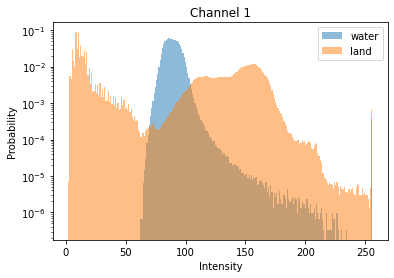


Random Forest
Elapsed_time training  45.751831 
Accuracy on train Set: 
0.9998163333333333
Accuracy on Test Set: 
0.9998325
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    999592
           1       1.00      1.00      1.00   1000408

    accuracy                           1.00   2000000
   macro avg       1.00      1.00      1.00   2000000
weighted avg       1.00      1.00      1.00   2000000

Confusion Matrix: 
[[ 999257     335]
 [      0 1000408]]


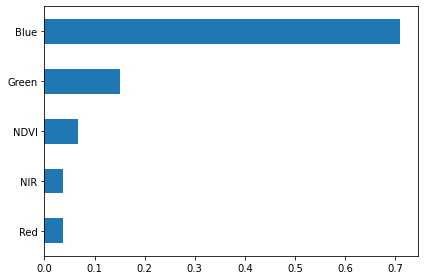

In [17]:
import numpy as np

tiff_filename = "./Data/Images/5_band1.tif"
shp_filename = "./Data/Labels/5_band1.shp"
combined_data = Data(tiff_filename, shp_filename, classes = ["water", "land"])
combined_tiff = combined_data.read_tiff() 
combined_mask = combined_data.get_mask()
X, y = data.get_Xy(combined_tiff, combined_mask, n_sample = 2000000)
tiff_filename = "./Data/Images/5_band15.tif"
shp_filename = "./Data/Labels/5_band15.shp"
combined_data = Data(tiff_filename, shp_filename, classes = ["water", "land"])
combined_tiff = combined_data.read_tiff() 
combined_mask = combined_data.get_mask()
_X, _y = data.get_Xy(combined_tiff, combined_mask, n_sample = 2000000)
X, y = np.concatenate((X, _X), axis = 0), np.concatenate((y, _y), axis = 0)
X_train, X_test, y_train, y_test = data.train_test_split(X, y, save=False)
data.get_histogram(X_train, y_train, channel = 1)
added_test_dataset = Dataset(X_train, X_test, y_train, y_test)
classifier.random_forest(trainX=added_test_dataset.trainX, trainY=added_test_dataset.trainY, testX=added_test_dataset.testX, testY=added_test_dataset.testY,
                   grid_search=False, train=True, n_estimators = 10, max_depth = 10, feature_importance=True)

### Using a folderpath as input

/home/ecology/.local/lib/python3.6/site-packages/pyproj/crs/crs.py:53: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  return _prepare_from_string(" ".join(pjargs))


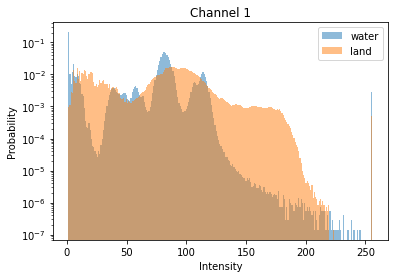

No. of classes: 2
Class labels: ['water', 'land']
Total data samples: 18815934
Train samples: 14111950
	 0:water = 7057265
	 1:land = 7054685
Test stats: 4703984
	 1:land = 2353282
	 0:water = 2350702

Random Forest
Elapsed_time training  199.498781 
Accuracy on train Set: 
0.9963099359053852
Accuracy on Test Set: 
0.9963371474052632
Classification Report: 
              precision    recall  f1-score   support

           0       1.00      1.00      1.00   2350702
           1       1.00      1.00      1.00   2353282

    accuracy                           1.00   4703984
   macro avg       1.00      1.00      1.00   4703984
weighted avg       1.00      1.00      1.00   4703984

Confusion Matrix: 
[[2341010    9692]
 [   7538 2345744]]


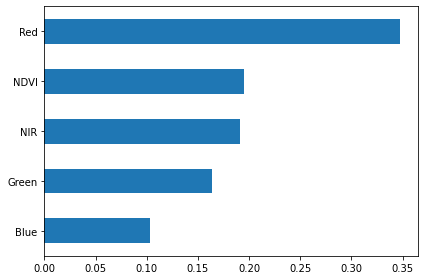

In [18]:
tiff_location = "./Data/Images/"
shp_location = "./Data/Labels/"
all_data = Data(tiff_location, shp_location, classes = ["water", "land"])
all_tiff = all_data.read_tiff() 
all_mask = all_data.get_mask()
X, y = all_data.get_Xy(all_tiff, all_mask, n_sample = 2000000)
X_train, X_test, y_train, y_test = all_data.train_test_split(X, y, save=False)
all_data.get_histogram(X_train, y_train, channel = 1)
all_dataset = Dataset(X_train, X_test, y_train, y_test)
all_dataset.info()
classifier.random_forest(trainX=all_dataset.trainX, trainY=all_dataset.trainY, testX=all_dataset.testX, testY=all_dataset.testY,
                   grid_search=False, train=True, n_estimators = 10, max_depth = 10, feature_importance=True)

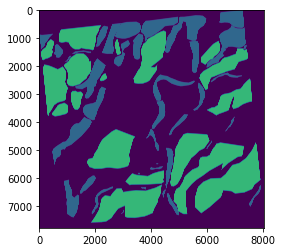

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


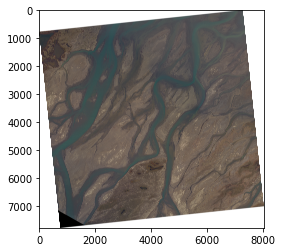

In [23]:
all_data.view_mask(all_mask[0])
all_data.view_tiff(all_tiff[0])
prediction = classifier.get_labels(all_tiff[0],"/estimator.sav")

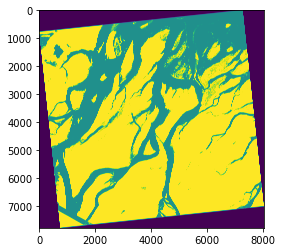

In [24]:
all_data.view_mask(prediction)